# Audio to Mel Spectrogram Conversion - Step by Step

This notebook demonstrates how to:
1. Load audio data
2. Visualize the audio waveform
3. Compute STFT (Short-Time Fourier Transform)
4. Convert to power spectrogram
5. Apply mel filterbank
6. Convert to mel spectrogram
7. Convert to log scale (dB)

## Step 1: Import Required Libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchaudio

# Set matplotlib style
plt.style.use('default')
%matplotlib inline

## Step 2: Load Audio File

We'll generate a sample audio signal (sine wave) for demonstration. You can replace this with your own audio file using `librosa.load('your_audio.wav')`

In [2]:
# Refresh PATH to find FFmpeg (needed after installation)
import os
import subprocess

result = subprocess.run(
    ['powershell', '-Command', 
     '[System.Environment]::GetEnvironmentVariable("Path","Machine") + ";" + [System.Environment]::GetEnvironmentVariable("Path","User")'],
    capture_output=True, text=True
)
os.environ['PATH'] = result.stdout.strip()

# Convert m4a to wav using pydub (uses system FFmpeg)
from pydub import AudioSegment

audio_m4a = AudioSegment.from_file('Recording (2).m4a', format='m4a')
wav_path = 'Recording_temp.wav'
audio_m4a.export(wav_path, format='wav')
print(f"Converted m4a to wav: {wav_path}")

# Load wav file using scipy (simple and reliable)
from scipy.io import wavfile
sample_rate_original, audio_data = wavfile.read(wav_path)

# Convert to float32 and normalize
if audio_data.dtype == np.int16:
    audio_signal = audio_data.astype(np.float32) / 32768.0
elif audio_data.dtype == np.int32:
    audio_signal = audio_data.astype(np.float32) / 2147483648.0
else:
    audio_signal = audio_data.astype(np.float32)

# Convert stereo to mono if needed
if len(audio_signal.shape) > 1:
    audio_signal = np.mean(audio_signal, axis=1)

# Resample to 22050 Hz if needed
if sample_rate_original != 22050:
    from scipy import signal
    num_samples = int(len(audio_signal) * 22050 / sample_rate_original)
    audio_signal = signal.resample(audio_signal, num_samples)
    sample_rate = 22050
else:
    sample_rate = sample_rate_original

print(f"Audio signal shape: {audio_signal.shape}")
print(f"Sample rate: {sample_rate} Hz")
print(f"Duration: {len(audio_signal) / sample_rate:.2f} seconds")
print(f"Original sample rate: {sample_rate_original} Hz")

# Clean up temp file
os.remove(wav_path)
print(f"Cleaned up temporary wav file")

Converted m4a to wav: Recording_temp.wav
Audio signal shape: (71030,)
Sample rate: 22050 Hz
Duration: 3.22 seconds
Original sample rate: 48000 Hz
Cleaned up temporary wav file


## Step 3: Visualize the Audio Waveform (Time Domain)

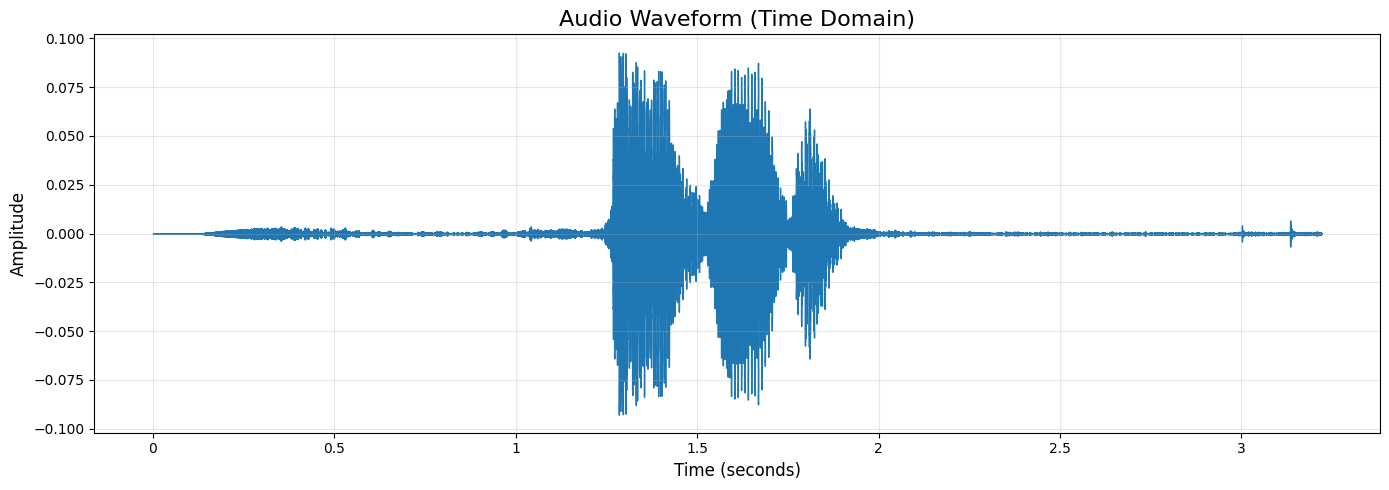

Time domain representation shows amplitude variations over time


In [3]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_signal, sr=sample_rate)
plt.title('Audio Waveform (Time Domain)', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Time domain representation shows amplitude variations over time")

## Step 4: Compute STFT (Short-Time Fourier Transform)

STFT breaks the signal into small time windows and computes the Fourier Transform for each window.

In [4]:
# STFT parameters
n_fft = 2048  # FFT window size
hop_length = 512  # Number of samples between successive frames
win_length = 2048  # Window length

# Compute STFT (returns complex-valued matrix)
stft = librosa.stft(audio_signal, n_fft=n_fft, hop_length=hop_length, win_length=win_length)

print(f"STFT shape: {stft.shape}")
print(f"STFT is complex-valued: {np.iscomplexobj(stft)}")
print(f"Frequency bins: {stft.shape[0]}")
print(f"Time frames: {stft.shape[1]}")
print(f"\nSTFT converts time-domain signal to time-frequency representation")

STFT shape: (1025, 139)
STFT is complex-valued: True
Frequency bins: 1025
Time frames: 139

STFT converts time-domain signal to time-frequency representation


## Step 5: Convert to Power Spectrogram

Calculate the magnitude (amplitude) and then square it to get power.

Power Spectrogram shape: (1025, 139)
Power Spectrogram is real-valued: True
Min value: 0.000000
Max value: 531.552551


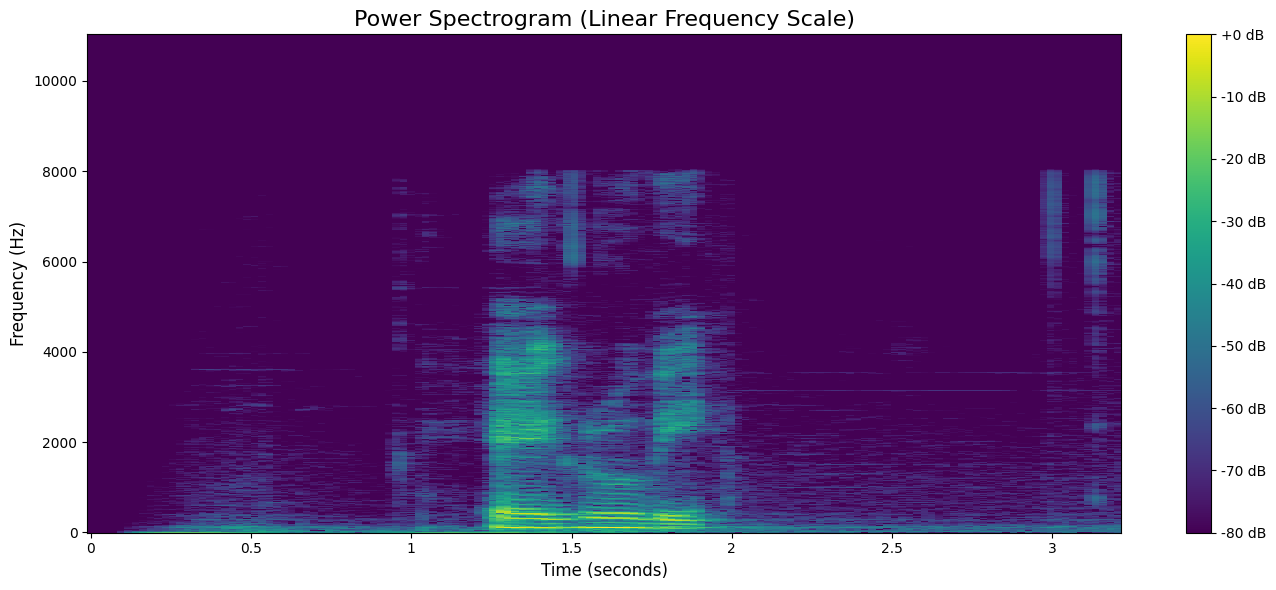

In [5]:
# Convert complex STFT to power spectrogram
# Power = |STFT|^2
power_spectrogram = np.abs(stft) ** 2

print(f"Power Spectrogram shape: {power_spectrogram.shape}")
print(f"Power Spectrogram is real-valued: {not np.iscomplexobj(power_spectrogram)}")
print(f"Min value: {power_spectrogram.min():.6f}")
print(f"Max value: {power_spectrogram.max():.6f}")

# Visualize power spectrogram
plt.figure(figsize=(14, 6))
librosa.display.specshow(librosa.power_to_db(power_spectrogram, ref=np.max),
                         sr=sample_rate, hop_length=hop_length,
                         x_axis='time', y_axis='hz', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Power Spectrogram (Linear Frequency Scale)', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Frequency (Hz)', fontsize=12)
plt.tight_layout()
plt.show()

## Step 6: Create Mel Filterbank

The Mel scale is a perceptual scale of pitches that better represents how humans perceive frequency differences.

Mel Filterbank shape: (128, 1025)
Number of mel bands: 128
Number of frequency bins: 1025


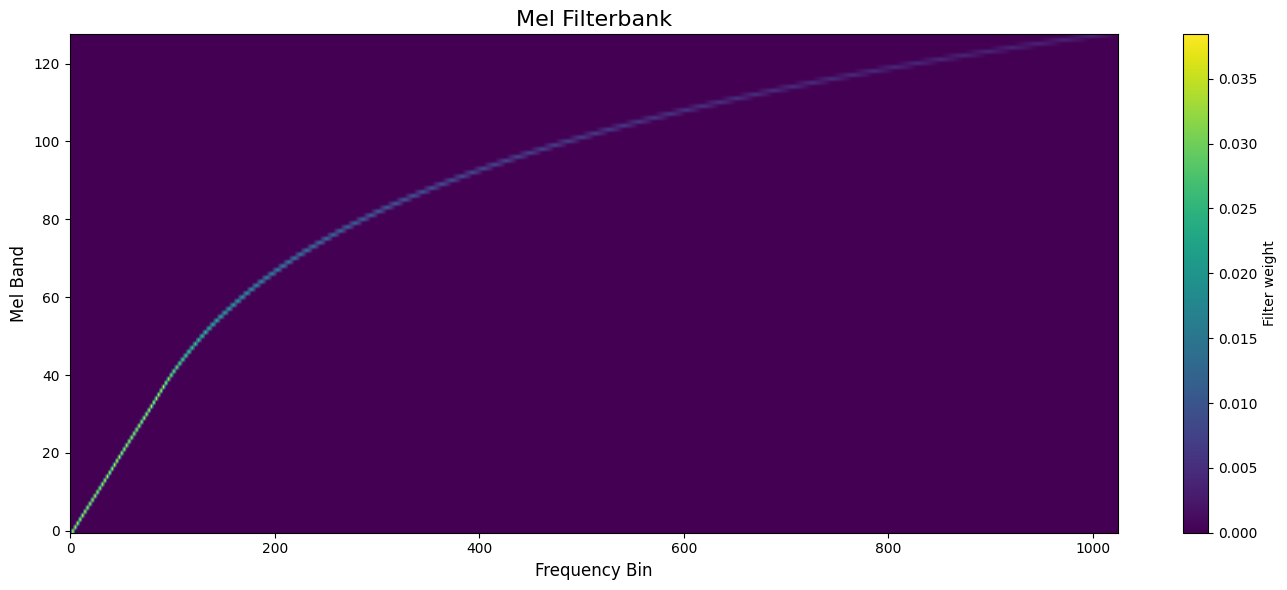


Mel filterbank maps linear frequency bins to mel-scale bands


In [6]:
# Create mel filterbank
n_mels = 128  # Number of mel bands

mel_filterbank = librosa.filters.mel(sr=sample_rate, n_fft=n_fft, n_mels=n_mels)

print(f"Mel Filterbank shape: {mel_filterbank.shape}")
print(f"Number of mel bands: {n_mels}")
print(f"Number of frequency bins: {n_fft // 2 + 1}")

# Visualize mel filterbank
plt.figure(figsize=(14, 6))
plt.imshow(mel_filterbank, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Filter weight')
plt.title('Mel Filterbank', fontsize=16)
plt.xlabel('Frequency Bin', fontsize=12)
plt.ylabel('Mel Band', fontsize=12)
plt.tight_layout()
plt.show()

print("\nMel filterbank maps linear frequency bins to mel-scale bands")

## Step 7: Apply Mel Filterbank to Power Spectrogram

Multiply the mel filterbank with the power spectrogram to get the mel spectrogram.

In [7]:
# Apply mel filterbank to power spectrogram
mel_spectrogram = np.dot(mel_filterbank, power_spectrogram)

print(f"Mel Spectrogram shape: {mel_spectrogram.shape}")
print(f"Number of mel bands: {mel_spectrogram.shape[0]}")
print(f"Number of time frames: {mel_spectrogram.shape[1]}")
print(f"\nMel spectrogram represents energy in each mel band over time")

Mel Spectrogram shape: (128, 139)
Number of mel bands: 128
Number of time frames: 139

Mel spectrogram represents energy in each mel band over time


## Step 8: Convert to Log Scale (Decibels)

Convert to logarithmic scale to better represent human perception of loudness.

Mel Spectrogram (dB) shape: (128, 139)
Min value: -80.00 dB
Max value: 0.00 dB


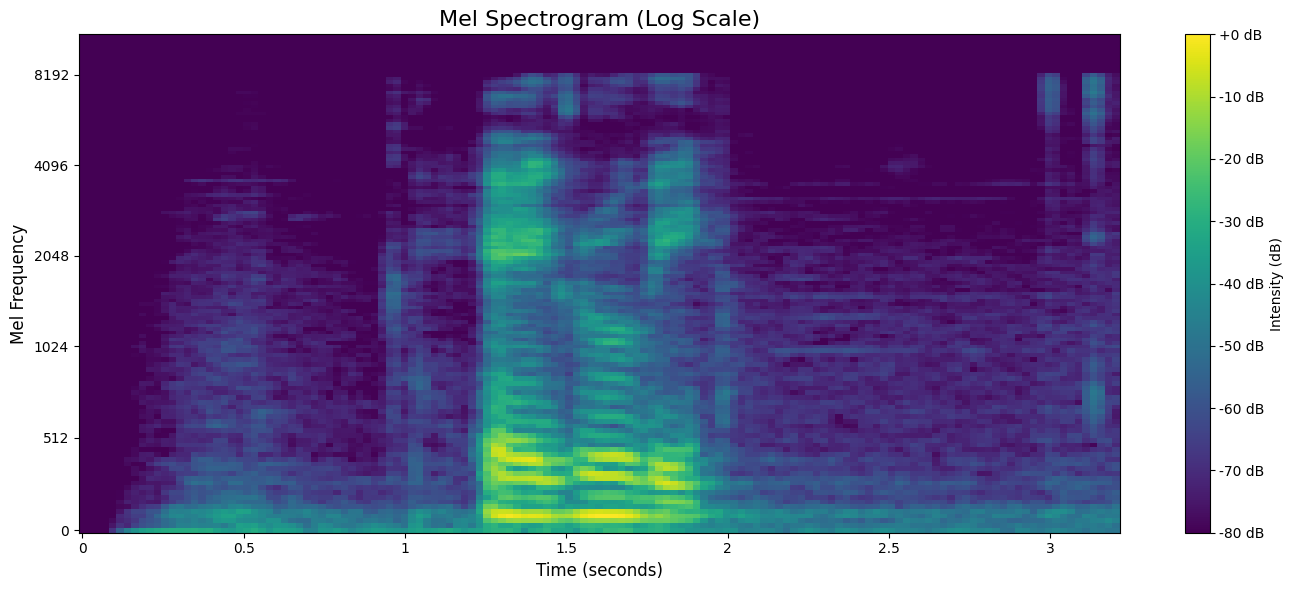

In [8]:
# Convert to log scale (dB)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

print(f"Mel Spectrogram (dB) shape: {mel_spectrogram_db.shape}")
print(f"Min value: {mel_spectrogram_db.min():.2f} dB")
print(f"Max value: {mel_spectrogram_db.max():.2f} dB")

# Visualize final mel spectrogram
plt.figure(figsize=(14, 6))
librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, hop_length=hop_length,
                         x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB', label='Intensity (dB)')
plt.title('Mel Spectrogram (Log Scale)', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Mel Frequency', fontsize=12)
plt.tight_layout()
plt.show()

## Step 9: Alternative - Using Librosa's Built-in Function

For comparison, here's how to do it all in one step using librosa's built-in function.

Maximum difference between manual and librosa method: 0.0000000000
Are they essentially identical? True


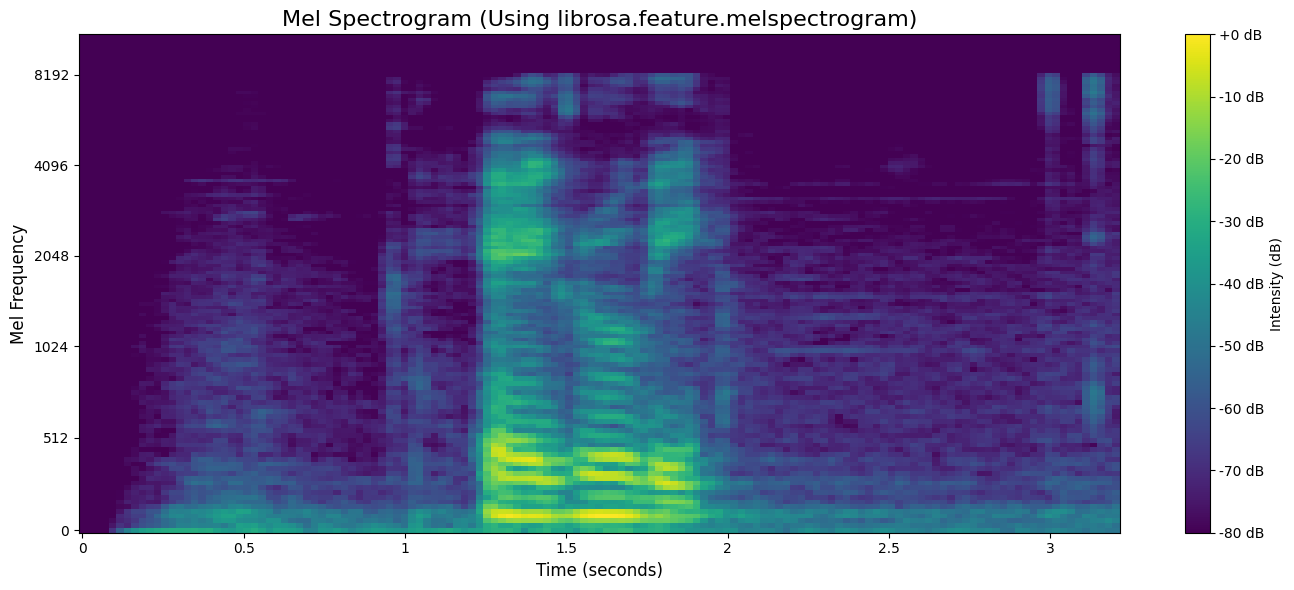

In [9]:
# One-step mel spectrogram using librosa
mel_spec_librosa = librosa.feature.melspectrogram(y=audio_signal, sr=sample_rate, 
                                                   n_fft=n_fft, hop_length=hop_length,
                                                   n_mels=n_mels)
mel_spec_librosa_db = librosa.power_to_db(mel_spec_librosa, ref=np.max)

# Verify they're the same
difference = np.abs(mel_spectrogram_db - mel_spec_librosa_db)
print(f"Maximum difference between manual and librosa method: {difference.max():.10f}")
print(f"Are they essentially identical? {np.allclose(mel_spectrogram_db, mel_spec_librosa_db)}")

# Visualize
plt.figure(figsize=(14, 6))
librosa.display.specshow(mel_spec_librosa_db, sr=sample_rate, hop_length=hop_length,
                         x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB', label='Intensity (dB)')
plt.title('Mel Spectrogram (Using librosa.feature.melspectrogram)', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Mel Frequency', fontsize=12)
plt.tight_layout()
plt.show()

## Step 10: Using PyTorch/TorchAudio

For deep learning applications, you might want to use PyTorch tensors.

PyTorch Mel Spectrogram shape: torch.Size([128, 139])
Data type: torch.float32


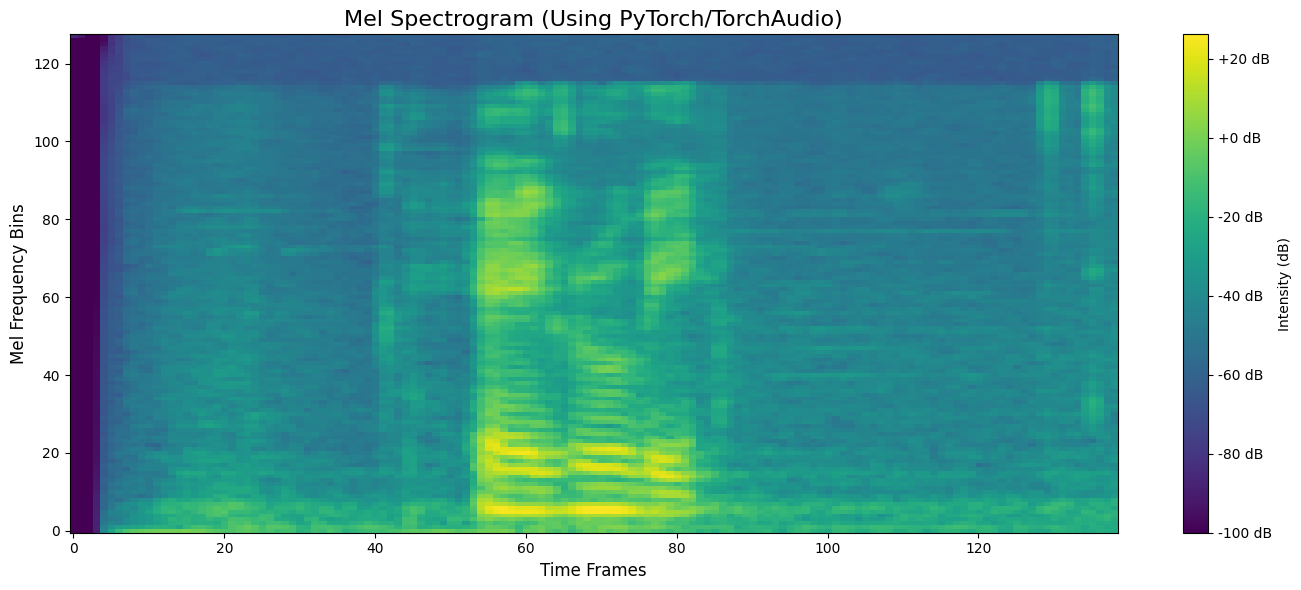

In [10]:
# Convert audio to PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal).float()

# Create mel spectrogram transform
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)

# Apply transform
mel_spec_torch = mel_transform(audio_tensor)

# Convert to dB
mel_spec_torch_db = torchaudio.transforms.AmplitudeToDB()(mel_spec_torch)

print(f"PyTorch Mel Spectrogram shape: {mel_spec_torch_db.shape}")
print(f"Data type: {mel_spec_torch_db.dtype}")

# Visualize
plt.figure(figsize=(14, 6))
plt.imshow(mel_spec_torch_db.numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB', label='Intensity (dB)')
plt.title('Mel Spectrogram (Using PyTorch/TorchAudio)', fontsize=16)
plt.xlabel('Time Frames', fontsize=12)
plt.ylabel('Mel Frequency Bins', fontsize=12)
plt.tight_layout()
plt.show()

## Summary of the Process

1. **Time Domain** → Audio waveform (amplitude over time)
2. **STFT** → Convert to frequency domain (complex values)
3. **Power Spectrogram** → Square magnitude of STFT
4. **Mel Filterbank** → Create filters for mel scale
5. **Mel Spectrogram** → Apply mel filterbank to power spectrogram
6. **Log Scale** → Convert to dB for better visualization

**Key Parameters:**
- `n_fft`: FFT window size (frequency resolution)
- `hop_length`: Step size between windows (time resolution)
- `n_mels`: Number of mel frequency bands
- `sample_rate`: Audio sampling rate